## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [132]:
data = pd.read_csv('/Users/Anna/Study/skillfactory/practice/data_practice/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [133]:
# ваш код здесь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


object

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [134]:
# ваш код здесь
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.groupby(['group'])['date'].agg(['max', 'min'])

,max,min
group,,
A,2021-01-24,2021-01-02
B,2021-01-24,2021-01-02


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [135]:
# ваш код здесь
data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index()



,group,user_id,purchase,price
0,A,147202,17723,1436260000
1,B,147276,17514,1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [136]:
# ваш код здесь
set_a = set(data[data['group']=='A']['user_id'])
set_b = set(data[data['group']=='B']['user_id'])
user_intersection = set_a.intersection(set_b)
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [137]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

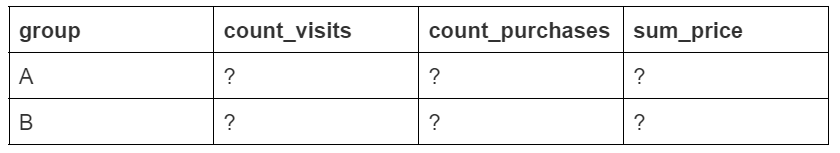
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [138]:
# ваш код здесь
df = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase':'count_purchases', 'price':'sum_price'}) 

Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

ваши выводы здесь
Все показатели выше в группе В, а значит, данные нужно нормализовать, чтобы получить объективные результаты

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [139]:
# ваш код здесь
df['conversion'] = round((df['count_purchases']/df['count_visits']*100),2)
df['mean_check'] = round(df['sum_price']/df['count_purchases'])
df

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

ваши выводы здесь
В группе А конверсия оказалась больше, однако сумма среднего чека ниже, чем в группе В. Пока о различии вариантов судить сложно

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [140]:
# ваш код здесь
df_buy = updated_data.groupby(['group', 'price'])['purchase'].sum().unstack()
df_buy = df_buy.drop([0], axis = 1)
df_buy

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot: xlabel='price', ylabel='group'>

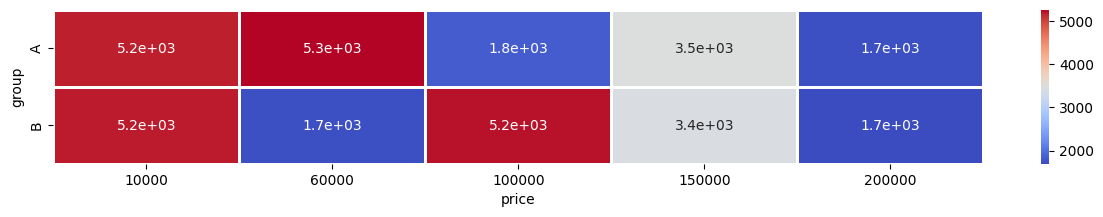

In [141]:
# ваш код здесь
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(df_buy, annot=True, linewidths=.9, ax=ax, cmap='coolwarm')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

ваши выводы здесь
Количество проданных туров за 60000 рублей в группе А - 5271, в группе В - 1730.
Выглядит, как будто в группе А покупали более дещевые туры, однако сильных различий не наблюдается.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [142]:
# ваш код здесь
df_daily = updated_data.groupby(['group', 'date']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase':'count_purchases', 'price':'sum_price'}) 
df_daily['conversion'] = round((df_daily['count_purchases']/df_daily['count_visits']*100),2)
df_daily['mean_check'] = round(df_daily['sum_price']/df_daily['count_purchases'])


In [143]:
df_daily.head()

,group,date,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,2021-01-02,2854,359,29410000,12.58,81922.0
1,A,2021-01-03,6596,748,62000000,11.34,82888.0
2,A,2021-01-04,6566,799,64250000,12.17,80413.0
3,A,2021-01-05,6433,790,64550000,12.28,81709.0
4,A,2021-01-06,6606,764,63410000,11.57,82997.0


In [144]:
exp = df_daily.groupby(['group'])
exp.head()

,group,date,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,2021-01-02,2854,359,29410000,12.58,81922.0
1,A,2021-01-03,6596,748,62000000,11.34,82888.0
2,A,2021-01-04,6566,799,64250000,12.17,80413.0
3,A,2021-01-05,6433,790,64550000,12.28,81709.0
4,A,2021-01-06,6606,764,63410000,11.57,82997.0
23,B,2021-01-02,2861,345,29660000,12.06,85971.0
24,B,2021-01-03,6619,754,65960000,11.39,87480.0
25,B,2021-01-04,6536,764,68030000,11.69,89045.0
26,B,2021-01-05,6511,749,63550000,11.50,84846.0
27,B,2021-01-06,6751,838,75020000,12.41,89523.0


In [145]:
df_daily[df_daily['date']=='2021-01-03']['conversion']

1     11.34
24    11.39
Name: conversion, dtype: float64

In [146]:
df_daily[df_daily['date']=='2021-01-03']['mean_check']

1     82888.0
24    87480.0
Name: mean_check, dtype: float64

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [147]:
# ваш код здесь
df_daily['cum_visits'] = df_daily.groupby(['group'])['count_visits'].cumsum()
df_daily['cum_purchases'] = df_daily.groupby(['group'])['count_purchases'].cumsum()
df_daily['cum_sum_price'] = df_daily.groupby(['group'])['sum_price'].cumsum()

df_daily['cum_conversion'] = round((df_daily['cum_purchases']/df_daily['cum_visits']*100),2)
df_daily['cum_mean_check'] = round(df_daily['cum_sum_price']/df_daily['cum_purchases'])


In [148]:
df_daily[(df_daily['date']=='2021-01-20')&(df_daily['group']=='B')]['cum_conversion']

41    11.9
Name: cum_conversion, dtype: float64

In [149]:
df_daily[(df_daily['date']=='2021-01-12')&(df_daily['group']=='A')]['cum_mean_check']

10    81492.0
Name: cum_mean_check, dtype: float64

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

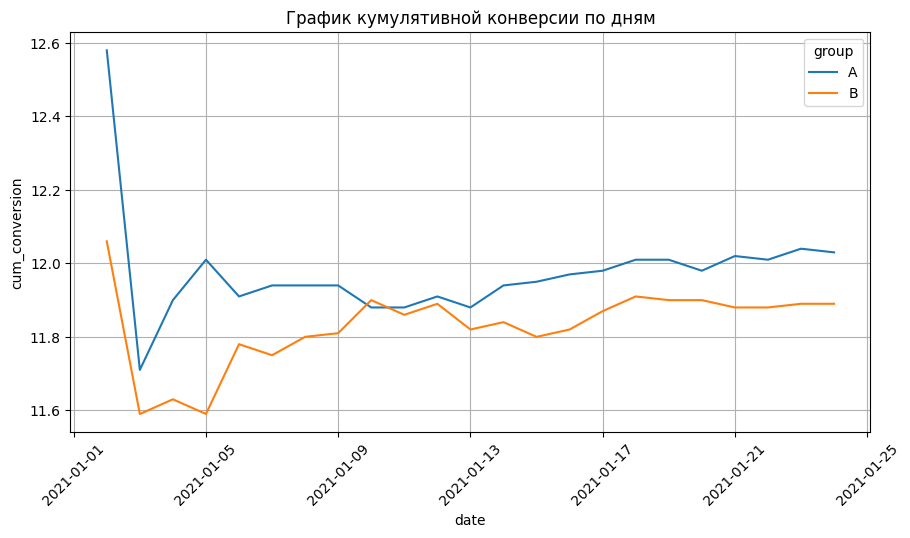

In [150]:
# ваш код здесь
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=df_daily, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

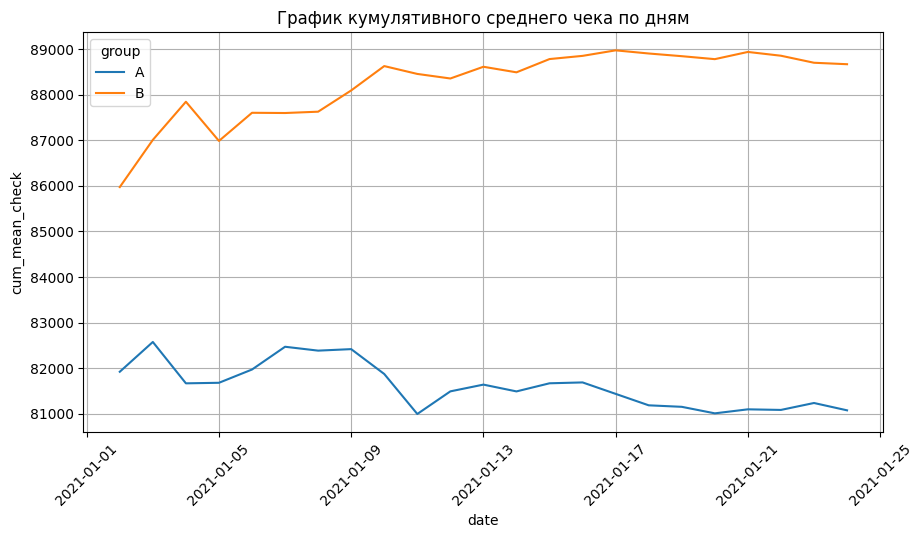

In [151]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=df_daily, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

ваши выводы здесь
Можно сказать, что данные стабилизированы. Мы видим почти отсутствие разницы в конверсии и огромную разницу в среднем чеке

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [152]:
# ваш код здесь
from statsmodels.stats import weightstats
_ ,p = weightstats.ztest(df_daily[df_daily['group']=="A"]['conversion'], x2=df_daily[df_daily['group']=="B"]['conversion'], value=0,alternative='two-sided')
print(float(p))

0.21282652662991042


In [153]:
from scipy.stats import ttest_ind
_ ,p = ttest_ind(df_daily[df_daily['group']=="A"]['conversion'], df_daily[df_daily['group']=="B"]['conversion'], equal_var=True)
p

0.2194196507603395

Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь
Статистической разницы нет

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [154]:
dfa = updated_data[updated_data['group']=="A"]
dfb = updated_data[updated_data['group']=="B"]
dfa.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
4,864975,2021-01-21,A,1,150000
5,936923,2021-01-10,A,0,0
7,719014,2021-01-17,A,0,0


In [155]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=dfa['user_id'].count(), # размер выборки
x_p=dfa['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=dfb['user_id'].count(), # размер выборки
x_p=dfb['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [156]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [dfa['user_id'].count(), dfb['user_id'].count()]
# выборочная пропорция групп A и B
xp = [dfa['purchase'].mean(), dfb['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [157]:
ваши выводы здесь
Доверительные интервалы пересекаются + ДИ для разности лежит между отрицательным и положительным числом - различия по конверсиям нет

SyntaxError: invalid syntax (2372506288.py, line 1)

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
# ваш код здесь
alpha = 0.05
# вычисляем результат теста Шапиро-Уилка для выборок

shapiro_result_a = shapiro(df_daily[df_daily['group']=='A']['mean_check'])
shapiro_result_b = shapiro(df_daily[df_daily['group']=='B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

p-value группы А 0.25
p-value группы B 0.09


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь
from scipy.stats import ttest_ind
_ ,p = ttest_ind(df_daily[df_daily['group']=="A"]['mean_check'], df_daily[df_daily['group']=="B"]['mean_check'], equal_var=True)
round(p,2)

0.0

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь
Значение р стремится к 0,  а значит статистическая разница есть

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [174]:
dfa_t.head()

,group,date,count_visits,count_purchases,sum_price,conversion,mean_check,cum_visits,cum_purchases,cum_sum_price,cum_conversion,cum_mean_check
0,A,2021-01-02,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.58,81922.0
1,A,2021-01-03,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.71,82575.0
2,A,2021-01-04,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.90,81668.0
3,A,2021-01-05,6433,790,64550000,12.28,81709.0,22449,2696,220210000,12.01,81680.0
4,A,2021-01-06,6606,764,63410000,11.57,82997.0,29055,3460,283620000,11.91,81971.0


In [175]:
# ваш код здесь
from scipy.stats import t

dfa_t = df_daily[df_daily['group']=='A']
dfb_t = df_daily[df_daily['group']=='B']

def proportions_conf_interval_t(n, x_p, std, gamma=0.95): 
    alpha = 1 - gamma # уровень значимости
    k=n-1
    t_crit = -t.ppf(alpha/2,k) # t-критическое
    eps = t_crit * std/(n ** 0.5) # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound), round(upper_bound))
    return confidence_interval

conf_interval_a_t = proportions_conf_interval_t(
x_p=dfa_t['mean_check'].mean(), 
n=dfa_t['date'].count(),
std = dfa_t['mean_check'].std()
)

conf_interval_b_t = proportions_conf_interval_t(
x_p=dfb_t['mean_check'].mean(), 
n=dfb_t['date'].count(),
std = dfb_t['mean_check'].std() 
)

print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a_t))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b_t))

Доверительный интервал для конверсии группы А: (79630, 82308)
Доверительный интервал для конверсии группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь
Пересечений нет, а значит, можно предположить, что в группе В дейсвительно средний чек выше

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Анализ показал, что дизайн не влияет на количество покупок, однако увеличивает вероятность покупки дорогих туров, что можно увидеть по частоте покупки  дорогих туров и приличной разнице в среднем чеке